# Homework for Week 6

In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor

In [49]:
df = pd.read_csv("car_fuel_efficiency.csv")
df = df.fillna(0)
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [50]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train["fuel_efficiency_mpg"]
del df_val["fuel_efficiency_mpg"]
del df_test["fuel_efficiency_mpg"]

In [51]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_dicts)

X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [52]:
dt = DecisionTreeRegressor(max_depth=1)  
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [53]:
# Q1 most important feature
from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [54]:
# Q2 
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [56]:
from sklearn.metrics import root_mean_squared_error

y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred,)
print(f"RMSE: {rmse}")

RMSE: 0.4595777223092725


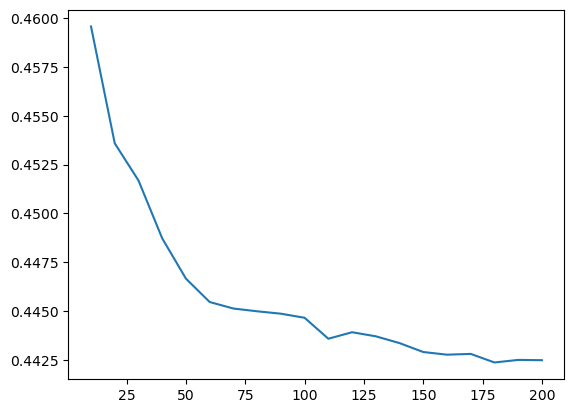

In [ ]:
# Q3:

results = []
n_estimator_values = list(range(10, 201, 10))

for n in n_estimator_values:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    rmse = root_mean_squared_error(y_val, rf.predict(X_val))
    results.append((n, rmse))


df_scores= pd.DataFrame(results, columns=["n_estimators", "rmse"])
plt.plot(df_scores.n_estimators, df_scores.rmse)


max_depth=10, mean RMSE=0.4418
max_depth=15, mean RMSE=0.4454
max_depth=20, mean RMSE=0.4463
max_depth=25, mean RMSE=0.4459

Best max_depth: 10 with mean RMSE: 0.4418


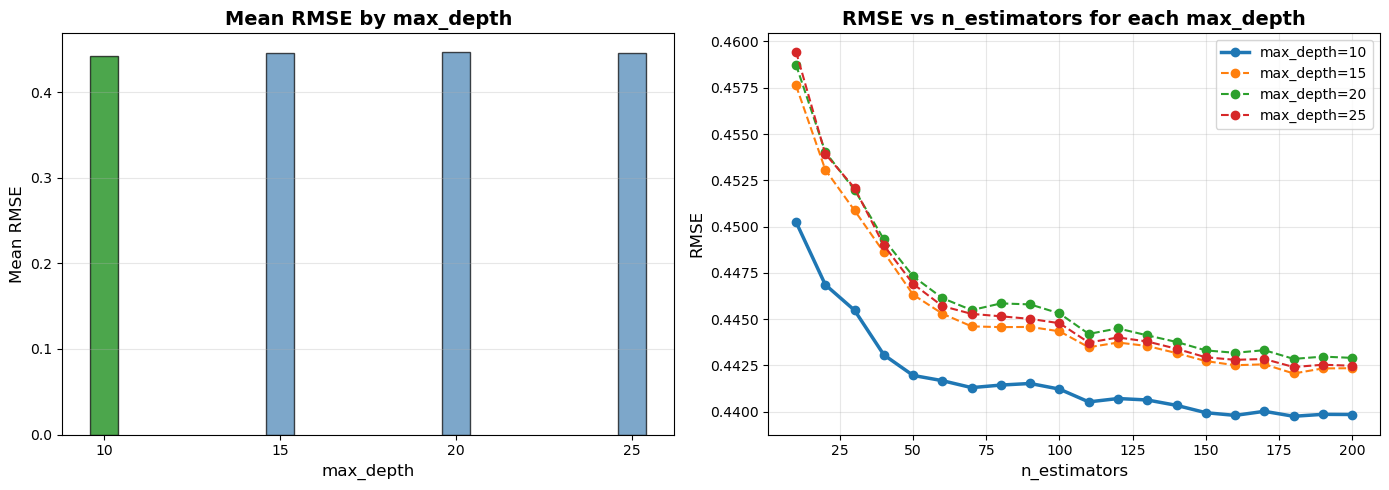

In [ ]:
# Q4
from sklearn.metrics import mean_squared_error

results = []
max_depth_values = [10, 15, 20, 25]
detailed_results = {md: [] for md in max_depth_values}

for md in max_depth_values:
    md_rmses = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=md, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        rmse = np.sqrt(mean_squared_error(y_val, rf.predict(X_val)))
        md_rmses.append(rmse)
        detailed_results[md].append((n, rmse))
    
    mean_rmse = np.mean(md_rmses)
    results.append((md, mean_rmse))
    print(f"max_depth={md}, mean RMSE={mean_rmse:.4f}")

# Find the best max_depth
best_md, best_rmse = min(results, key=lambda x: x[1])
print(f"\nBest max_depth: {best_md} with mean RMSE: {best_rmse:.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Mean RMSE by max_depth
md_values = [x[0] for x in results]
mean_rmses = [x[1] for x in results]
colors = ['green' if md == best_md else 'steelblue' for md in md_values]
ax1.bar(md_values, mean_rmses, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('max_depth', fontsize=12)
ax1.set_ylabel('Mean RMSE', fontsize=12)
ax1.set_title('Mean RMSE by max_depth', fontsize=14, fontweight='bold')
ax1.set_xticks(md_values)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: RMSE vs n_estimators for each max_depth
for md in max_depth_values:
    n_vals = [x[0] for x in detailed_results[md]]
    rmse_vals = [x[1] for x in detailed_results[md]]
    line_style = '-' if md == best_md else '--'
    line_width = 2.5 if md == best_md else 1.5
    ax2.plot(n_vals, rmse_vals, marker='o', label=f'max_depth={md}', 
             linestyle=line_style, linewidth=line_width)

ax2.set_xlabel('n_estimators', fontsize=12)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('RMSE vs n_estimators for each max_depth', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [89]:
# Q5: Feature Importance - train with n_estimators=10, max_depth=20
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature names and importances
feature_names = dv.get_feature_names_out()
importances = rf.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Filter for the 4 features in question
target_features = ['vehicle_weight', 'horsepower', 'acceleration', 'engine_displacement']
filtered_df = importance_df[importance_df['feature'].isin(target_features)]

print("Feature Importances (for the 4 features in question):")
print(filtered_df)
print(f"\nMost important feature: {filtered_df.iloc[0]['feature']}")
print(f"Importance: {filtered_df.iloc[0]['importance']:.4f}")

Feature Importances (for the 4 features in question):
                feature  importance
13       vehicle_weight    0.959150
6            horsepower    0.015998
0          acceleration    0.011480
3   engine_displacement    0.003273

Most important feature: vehicle_weight
Importance: 0.9591


In [90]:
# Q6: XGBoost with different eta values
import xgboost as xgb

# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Create watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Train with eta=0.3
print("Training with eta=0.3:")
xgb_params_03 = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_03 = xgb.train(xgb_params_03, dtrain, num_boost_round=100, 
                     evals=watchlist, verbose_eval=10)

# Get predictions and RMSE for eta=0.3
y_pred_03 = model_03.predict(dval)
rmse_03 = root_mean_squared_error(y_val, y_pred_03)
print(f"\nFinal RMSE with eta=0.3: {rmse_03:.4f}\n")

# Train with eta=0.1
print("="*60)
print("Training with eta=0.1:")
xgb_params_01 = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model_01 = xgb.train(xgb_params_01, dtrain, num_boost_round=100, 
                     evals=watchlist, verbose_eval=10)

# Get predictions and RMSE for eta=0.1
y_pred_01 = model_01.predict(dval)
rmse_01 = root_mean_squared_error(y_val, y_pred_01)
print(f"\nFinal RMSE with eta=0.1: {rmse_01:.4f}\n")

# Compare results
print("="*60)
print("COMPARISON:")
print(f"eta=0.3: RMSE = {rmse_03:.4f}")
print(f"eta=0.1: RMSE = {rmse_01:.4f}")
if rmse_03 < rmse_01:
    print("\nBest eta: 0.3")
elif rmse_01 < rmse_03:
    print("\nBest eta: 0.1")
else:
    print("\nBoth give equal value")

Training with eta=0.3:
[0]	train-rmse:1.81393	val-rmse:1.85444
[10]	train-rmse:0.37115	val-rmse:0.43896
[20]	train-rmse:0.33553	val-rmse:0.43376
[30]	train-rmse:0.31475	val-rmse:0.43752
[40]	train-rmse:0.30202	val-rmse:0.43968
[50]	train-rmse:0.28456	val-rmse:0.44140
[60]	train-rmse:0.26768	val-rmse:0.44290
[70]	train-rmse:0.25489	val-rmse:0.44531
[80]	train-rmse:0.24254	val-rmse:0.44689
[90]	train-rmse:0.23193	val-rmse:0.44839
[99]	train-rmse:0.21950	val-rmse:0.45018

Final RMSE with eta=0.3: 0.4502

Training with eta=0.1:
[0]	train-rmse:2.28944	val-rmse:2.34561
[10]	train-rmse:0.91008	val-rmse:0.94062
[20]	train-rmse:0.48983	val-rmse:0.53064
[30]	train-rmse:0.38342	val-rmse:0.44289
[40]	train-rmse:0.35343	val-rmse:0.42746
[50]	train-rmse:0.33998	val-rmse:0.42498
[60]	train-rmse:0.33054	val-rmse:0.42456
[70]	train-rmse:0.32202	val-rmse:0.42503
[80]	train-rmse:0.31667	val-rmse:0.42563
[90]	train-rmse:0.31059	val-rmse:0.42586
[99]	train-rmse:0.30419	val-rmse:0.42623

Final RMSE with eta